# Schibsted NLP Machine Learning Challenge #

In this task, you’ll be doing text classification on an open data set from Reuters. The task
formulation is a bit vague on purpose, enabling you to make your own choices where needed.
<br>
<br>

### Instructions ###

* Download the [Reuters data set](www.daviddlewis.com/resources/testcollections/reuters21578/reuters21578.tar.gz)
* Your task is to classify the documents to the categories found in TOPICS
* Adhere to the train/test split specified in the XML as LEWISSPLIT
* If you have time, evaluate and report the results
* Please submit a running piece of code, documented as you please (in the code, separate docs, document by tests, whatever makes the code understandable)
* We are interested in seeing your ideas, and your coding style/skills. Don’t worry if the classification results are sub-optimal
* If you have ideas on how to improve the solution further, please write that down as well
* Spend approximately 3 hours on the task
<br>
<br>

### Introduction ###

The Reuters dataset is given as 22 files in SGM format. SGM is an acronym for Standard Generalized Markup. Files that are saved with the . sgm file extension are written in the SGM programming language. The SGM language is a document generation language that is used to share information digitally using custom tags and DTD file references.

Each SGM file contains the body of an article, together with other important information, such as the topic(s) of the article, as well as whether it belongs to the training or testing set.

While researching how to parse the SGM files (as they couldn't be parsed using Python's internal `lxml` library), we ran across a [project](https://github.com/ankailou/reuters-preprocessing) on GitHub, written by Ankai Lou, which not only parses the SGM files, but also does a number of preprocessing and feature engineering steps (described below), which prepare our data for modeling. While inspecting the code in detail, we realized that using this library would greatle simplify the approach and solution of the classification problem.

It is our strong believe that Data Scientists should not reinvent the wheel, but build upon the previous work of colleagues, in the interest of efficiency and productivity. After all, one will, for example, rarely code a cross validation scheme from scratch, but rather rely on a pre-existing implementation, such as `scikit-learn`'s `cross_validate` or `KFold` functionality.

One small disadvantage of the existing `reuters-preprocessing` package is the fact that it is written for Python 2. While it is possible to have multiple versions of Python on the same machine, this may not be practicle. Thus, in the interest of full reproducibility, we forked the project and amended the code to work in Python 3. We also changed some of the functionality, namely the way the topics are generated, as well as the way TF-IDF values are calculated (instead of the original author's implementation, we opted to use `scikit-learn`'s `TfdfVectorizer`).

The forked and updated version can be found [here](https://github.com/ssantic/reuters-preprocessing), or directly cloned through this notebook:

In [ ]:
!git clone https://github.com/ssantic/reuters-preprocessing

The `reuters-preprocessing` library does a number of things:

* For each file, the `BeautifulSoup4` library is used to generate a parse-tree from the SGML using the built-in Python `html.parser` library:
    * For each parse-tree, article blocks - delimited by `<reuters>` - are separated into strings.
    * For each article, the text in `<topics>` and `<places>` delimited by `<d>` is used as class labels; the text in `<title>` and `<body>` is extracted for tokenization.

* For each title/body text block, the `NLTK` and `string` libraries are used for tokenization:     
    * For each field, digits & unicode symbols are replaced by `None` using the `string` library.
    * For each field, punctuation symbols are replaced by `None` using the `string` library.
    * For each field, text blocks are tokenized into lists using `nltk.word_tokenize()`.
    * For the tokens, `stopwords` from `nltk.corpus` are filtered from the lists.
    * For the tokens, non-English words are filtered via `nltk.corpus.wordnet.synsets()`.
    * For the tokens, lemmatization is used via `nltk.stem.wordnet.WordLemmatizer()`.
    * For the tokens, tokens are stemmed via `nltk.stem.porter.PorterStemmer()`.
    * For each stem list, the word stems shorter than 4 characters are filtered from the list.

The final output of the text extraction & processing phase is a list of documents:

```
documents = [document = {'topics' : [], 'places' : [], 'words' : {'title' : [], 'body' : []}}]
```

From this list, a lexicon is generated for all unique words in titles and body fields:

```
lexicon = {'title' = set() : 'body' = set()}
```

This concludes the text extraction and processing phase and prepares the file input for feature selection.

<br>
<br>

### Rationale ###

Several portions of the text processing & tokenization phase are selected for specific reasons:

* Digits, unicode characters, and punctuation symbols are removed from the text because digits & meta-characters provide less valuable information to article context than actual words.
* Stopwords are removed from the text because words such as `the` are frequently present yet provide no contextual value. Though the TF-IDF process would inevitably filter stopwords during the weighting phase, removing stopwords at tokenization removes several polynomial time calculations during the TF-IDF calculations in linear time - a desirable improvement in performance.
* Non-English words are filtered from the text because the stemmer used is the English Porter stemmer; therefore, stemming non-English words is likely to produce erroneous data and artificially inflate the size of the lexicon - which will increase the runtime.
* Tokens are lemmatized to reduce the dataset by removing tenses before stemming.
* Tokens are stemmed to reduce the dataset further by minimizing the size of the lexicon.
* Stems shorter than 4 characters are filtered because sufficiently short stems appear frequently in articles yet provide little importance to classification - similar to stop words.

This minification of the tokens & lexicon ensure a minimum number of calculations during the selection phase, while not losing valuable information or context. The same feature reduction process was used for all feature vectors because filtering out low-value words & stems from the data is low-risk/high-reward for data quality and runtime. A unified text processing methodology also reduced the runtime.

Using the `scikit-learn` python module, the `TfidfVectorizer` submodule in the python submodule `feature_extraction.text` provides functionality for performing td-idf on a set of documents. The use of the built-in `scikit-learn` TF-IDF is based on the assumption that their TF-IDF calculator is far more sophisticated than any TF-IDF weight generator that can be manually coded. The purpose of generating this dataset is to observe the differences between a naive TF-IDF weighting and a far more complex iteration. The weighting and calculations are all left to the `scikit-learn` module.

We can run the preprocessing and feature engineering steps automatically, executing a command directly from the notebook (with the warning that it takes a while):

In [ ]:
!python preprocess.py

This will generate a `dataset.csv` file, which we will be working with for the rest of this project.

<br>
<br>

### Imports ###

In [1]:
import os
import ast
import pandas as pd
import numpy as np
import tensorflow as tf
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt

<br>
<br>

The `reuters-preprocessing` library doesn't do one thing - it doesn't parse `LEWISSPLIT` information on whether the article belongs to the training set, or the testing set. We'll do that next here.

In [2]:
split_info = []
for file in os.listdir('data'):
    data = open(os.path.join(os.getcwd(), "data", file), 'r')
    text = data.read()
    data.close()
    tree = BeautifulSoup(text.lower(), "html.parser")
    print("Extracting train/test information from file", file)
    for i in range(len(tree.find_all("reuters"))):
        if 'lewissplit="train"' in str(tree.find_all("reuters")[i]):
            split_info.append('train')
        else:
            split_info.append('test')

Extracting train/test information from file reut2-000.sgm
Extracting train/test information from file reut2-001.sgm
Extracting train/test information from file reut2-002.sgm
Extracting train/test information from file reut2-003.sgm
Extracting train/test information from file reut2-004.sgm
Extracting train/test information from file reut2-005.sgm
Extracting train/test information from file reut2-006.sgm
Extracting train/test information from file reut2-007.sgm
Extracting train/test information from file reut2-008.sgm
Extracting train/test information from file reut2-009.sgm
Extracting train/test information from file reut2-010.sgm
Extracting train/test information from file reut2-011.sgm
Extracting train/test information from file reut2-012.sgm
Extracting train/test information from file reut2-013.sgm
Extracting train/test information from file reut2-014.sgm
Extracting train/test information from file reut2-015.sgm
Extracting train/test information from file reut2-016.sgm
Extracting tra

<br>
<br>
We can now load the tab-delimited dataset.

In [3]:
df = pd.read_csv('C:/Schibsted-Homework/dataset.csv', sep='\t')

In [4]:
df.head()

,id,aaron,abandon,abat,abbey,abbrevi,abduct,abel,abet,abid,...,zimbabwean,zimmer,zinc,zirconium,zloti,zone,zurich,zweig,class-label:topics,Unnamed: 7836
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.059531,0.0,0.0,['cocoa'],NaN
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,[],NaN
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,[],NaN
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,[],NaN
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",NaN


<br>
<br>

### Data Preparation ###

Upon inspection, we can see that some of the topics are unlabeled (actually, they're labeled as an empty list `[]`). We're going to tag these topics as `['unlabeled']`.

In [5]:
df['class-label:topics'] = df['class-label:topics'].apply(lambda x: "['unlabeled']" if x == '[]' else x)

<br>
<br>
Another problem we have is that some of the articles have topics with multiple tags. To make things simpler, we've made the decision to use only the first topic from the list of topics in these cases.

In [6]:
topics = []
for index, row in df.iterrows():
    topics.append(ast.literal_eval(df['class-label:topics'][index])[0])

# Add the new 'topics' column to the dataframe
df['topics'] = topics

<br>
<br>
We have some unnecessary columns now, so let's remove them.

In [7]:
del df['id']
del df['class-label:topics']
del df['Unnamed: 7836']

<br>
<br>
We previously parsed the information about the train/test split, so let's add that column, as we'll need it to prepare the datasets for modeling.

In [8]:
df['split_info'] = split_info

<br>
<br>
Splits of 80:20 or 70:30 are usual practice, so let's see what we're working with here.

In [9]:
df['split_info'].value_counts(normalize=True)

train    0.679766
test     0.320234
Name: split_info, dtype: float64

<br>
<br>
The next step is to split the data into training and testing. We'll also drop some columns from the features dataframes, so that they contain only features. We'll also inspect the dataframes quickly.

In [10]:
df_train = df[df['split_info'] == 'train']
y_train = df_train['topics']
X_train = df_train.drop(['split_info', 'topics'], axis=1)

In [11]:
df_test = df[df['split_info'] == 'test']
y_test = df_test['topics']
X_test = df_test.drop(['split_info', 'topics'], axis=1)

In [12]:
X_train.head()

,aaron,abandon,abat,abbey,abbrevi,abduct,abel,abet,abid,abidjan,...,ziegler,zimbabw,zimbabwean,zimmer,zinc,zirconium,zloti,zone,zurich,zweig
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059531,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [13]:
X_test.head()

,aaron,abandon,abat,abbey,abbrevi,abduct,abel,abet,abid,abidjan,...,ziegler,zimbabw,zimbabwean,zimmer,zinc,zirconium,zloti,zone,zurich,zweig
12593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>
<br>

### Machine Learning Modeling ###

First we'll go with "classical" Machine Learning algorithms. There are several that we could try, such as Multinomial Naive Bayes, or Support Vector Machines. But Random Forests are our favorite algorithm, so we'll go with that. They usually provide very good accuracy "out of the box", aren't prone to overfitting, and do automatic feature selection. Here we'll train a Random Forest classifier with 1000 trees. We'll also set the seed for the random number generator for reproducibility. We'll also generate the predictions on the test set.

In [14]:
rfc = RandomForestClassifier(random_state=176, n_estimators=1000).fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

<br>
<br>
There's a number of accuracy metrics that we can calculate, including the overall Accuracy, the overal Balanced Accuracy, Precision, Recall, and the F1 Score (the harmonic mean of Precision and Recall).

In [16]:
accuracy = accuracy_score(y_test, rfc_preds)
balanced_acc = balanced_accuracy_score(y_test, rfc_preds)
precision = precision_score(y_test, rfc_preds, average='macro')
recall = recall_score(y_test, rfc_preds, average='macro')
f1 = f1_score(y_test, rfc_preds, average='macro')

In [17]:
metrics = {'Metrics': [accuracy, balanced_acc, precision, recall, f1]}
metrics_df = pd.DataFrame(metrics, index=['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_df

,Metrics
Accuracy,0.719103
Balanced Accuracy,0.184140
Precision,0.435045
Recall,0.181509
F1 Score,0.224871


<br>
<br>
The overall Accuracy is pretty good - 72% on the test set. The other metrics, when looking at the whole picture, aren't that great. But looking at overall metrics is generally not enough. Next, we take a look at the classification report, which shows us some metrics per topic - a much better indicator of performance.

In [19]:
classification_report(y_test, rfc_preds)

'                 precision    recall  f1-score   support\n\n            acq       0.87      0.74      0.80       791\n           alum       1.00      0.05      0.09        22\n            bop       1.00      0.18      0.31        22\n        carcass       0.00      0.00      0.00         9\n          cocoa       1.00      0.26      0.42        19\n        coconut       0.00      0.00      0.00         1\n         coffee       1.00      0.59      0.74        27\n         copper       1.00      0.20      0.33        25\n           corn       0.00      0.00      0.00         1\n         cotton       1.00      0.09      0.17        11\n            cpi       0.64      0.35      0.45        26\n            cpu       0.00      0.00      0.00         1\n          crude       0.91      0.55      0.69       212\n            dlr       0.00      0.00      0.00        26\n           earn       0.67      0.92      0.78      1106\n       f-cattle       0.00      0.00      0.00         2\n           

<br>
<br>
Now we have a much clearer picture. It's interesting to see that the metrics for the unlabeled articles are pretty good - surprising, at least to an extent.
<br>
<br>

### Deep Learning Modeling ###

Deep Neural Networks have shown to perform quite well on NLP tasks. While we don't have that much data, and Neural Networks are quite "hungry" when it comes to volumes of data, we'll try building a Neural Network with a few layers.
<br>
<br>
First, we need to prepare the data, as we can just use pandas dataframes. As we're using TensorFlow (through the Keras API), we're going to need to pass in Numpy arrays when it comes to the features.

In [20]:
X_train = X_train.values
X_test = X_test.values

<br>
<br>
The labels (topics) need to be one-hot encoded:

In [21]:
one_hot = MultiLabelBinarizer()
y_test = one_hot.fit_transform(y_test)
y_train = one_hot.fit_transform(y_train)

<br>
<br>
Let's build a network. We'll use just a few Dense layers, together with both L1 Regularization, as well as Dropout, to prevent overfitting. We're going to be using the Rectified Linear Unit activation function (ReLU) for the intermediate Dense layers, and the Softmax activation function for the output layer.

In [22]:
model = models.Sequential()
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(7834,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2005760   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                6939      
Total params: 2,078,491
Trainable params: 2,078,491
Non-trainable params: 0
_________________________________________________________________


<br>
<br>
Next, we compile, fit, and evaluate our network.

In [23]:
num_epochs = 10
batch_size= 512

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

results = model.evaluate(X_test, y_test)
print("Test Loss and Accuracy")
print("results ", results)

history_dict = history.history

Train on 14668 samples, validate on 6910 samples
Epoch 1/10
14668/14668 [==============================] - 2s 134us/sample - loss: 27.8982 - accuracy: 0.7317 - val_loss: 30.6330 - val_accuracy: 0.8259
Epoch 2/10
14668/14668 [==============================] - 1s 52us/sample - loss: 55.1658 - accuracy: 0.5715 - val_loss: 74.1176 - val_accuracy: 0.8259
Epoch 3/10
14668/14668 [==============================] - 1s 53us/sample - loss: 123.2093 - accuracy: 0.4855 - val_loss: 145.9159 - val_accuracy: 0.8259
Epoch 4/10
14668/14668 [==============================] - 1s 53us/sample - loss: 218.4426 - accuracy: 0.4650 - val_loss: 234.6495 - val_accuracy: 0.8259
Epoch 5/10
14668/14668 [==============================] - 1s 58us/sample - loss: 339.6159 - accuracy: 0.4458 - val_loss: 345.6255 - val_accuracy: 0.8259
Epoch 6/10
14668/14668 [==============================] - 1s 54us/sample - loss: 485.2944 - accuracy: 0.4344 - val_loss: 476.1316 - val_accuracy: 0.8259
Epoch 7/10
14668/14668 [============

Test Loss and Accuracy
results  [1201.6818340649309, 0.8259045]


<br>
<br>
The results are good - an accuracy of 82%! The network is most probably overfitting. Significantly better than our Random Forest. Let's take a look at our Loss and Accuracy curves.

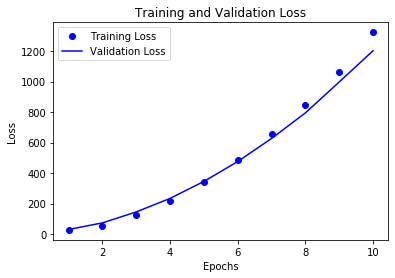

In [24]:
# Loss Curves
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

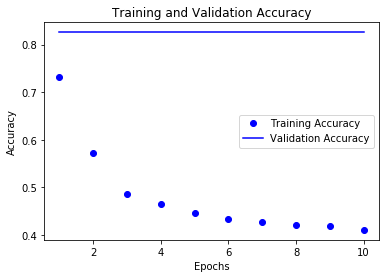

In [25]:
# Accuracy Curves
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<br>
<br>
Let's compile, fit and evaluate the new network.

<br>
<br>
We can see that there's no overfitting, though it is weird that the test set accuracy is significantly higher than the training set accuracy. This could indicate a problem with the train/test split, so the thing to do here, for future work, would be to try different training and testing splits. It would also make sense to do cross-validation, as it would be computationally feasible due to small dataset size.
<br>
<br>

### Thank you! ###